# Get quick analysis for Agra, Jaipur (starting point as Delhi


Get number of Covid cases from Agra & Jaipur
Get Historic sites from Agra & Jaipur
Get food - resturants from Agra & Jaipur


In [1]:
!pip install geopy

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from pandas.io.json import json_normalize
import requests
import json

from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
!pip install folium
import folium

print ("librarys imported")

     |████████████████████████████████| 94 kB 3.8 MB/s  eta 0:00:01
librarys imported


In [7]:
import warnings
warnings. filterwarnings("ignore")

## install required libraries

## Get the covid case based on district

In [8]:
response = requests.get('https://api.covid19india.org/v2/state_district_wise.json')
content = response.content
parsed = json.loads(content)
len(parsed)

37

In [9]:
dfs = []

for i in parsed:
    #print(i['state'])
    state_name = i['state']
    state_code = i['statecode']
    
    #df = pd.DataFrame()
    df = pd.DataFrame(i['districtData'])
    df['state name'] = state_name
    df['state code'] = state_code
    
    dfs.append(df)

### Get the Covid Cases on Agra and Jaipur

In [10]:
district_level = pd.concat(dfs)

covid_DL = district_level[ ((district_level['district'] == 'Agra') | (district_level['district'] == 'Jaipur'))]
covid_DL

,district,notes,active,confirmed,deceased,recovered,delta,state name,state code
19,Jaipur,,1122,58445,510,56813,"{'confirmed': 0, 'deceased': 0, 'recovered': 0}",Rajasthan,RJ
0,Agra,,92,10421,171,10158,"{'confirmed': 0, 'deceased': 0, 'recovered': 0}",Uttar Pradesh,UP


In [11]:
# drop the columns named delta, notes, deceased and recovered

covid_DL.drop(["deceased","delta","notes"],axis=1,inplace=True)
covid_DL.drop(["recovered"],axis=1,inplace=True)
covid_DL

,district,active,confirmed,state name,state code
19,Jaipur,1122,58445,Rajasthan,RJ
0,Agra,92,10421,Uttar Pradesh,UP


In [12]:
#Gelocator.geocode()

#get co-ordinates from Agra

from geopy.geocoders import Nominatim
address='Agra'
geolocator = Nominatim(user_agent="Your_Name")
location = geolocator.geocode(address)

agra_lat = location.latitude
agra_long = location.longitude

print((agra_lat, agra_long))

(27.1752554, 78.0098161)


In [13]:
#get co-ordinates from Jaipur
address='Jaipur'
location = geolocator.geocode(address)

jai_lat = location.latitude
jai_long = location.longitude

lat=[agra_lat, jai_lat]
long=[agra_long, jai_long]

covid_DL['Latitude']=lat
covid_DL['Longitude']=long

#covid_DL[covid_DL["district"] == "Jaipur"]["Latitude"]

# Get data from four square API

In [14]:
CLIENT_ID = 'Z4KKC3IVYPGH2W4AF1VIGVBZSYXQMFGBTTM3HSFHNCHINQLY' # your Foursquare ID
CLIENT_SECRET = '4LTAK5LWGCLL1DTICXXM5KFKOIGOZQ5Z01N0VKNSSG0YB5T2' # your Foursquare Secret
ACCESS_TOKEN = 'YZVJUF3RN3P1JNUIYAZJEBTV1HHTAIUIDLZK3NH34RQX1JOE' # your FourSquare Access Token
VERSION = '20180604'

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
radius=4000 #4 km
LIMIT=100

Your credentials:
CLIENT_ID: Z4KKC3IVYPGH2W4AF1VIGVBZSYXQMFGBTTM3HSFHNCHINQLY
CLIENT_SECRET:4LTAK5LWGCLL1DTICXXM5KFKOIGOZQ5Z01N0VKNSSG0YB5T2


In [15]:
covid_DL['district']


19    Jaipur
0       Agra
Name: district, dtype: object

In [16]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [17]:
foursquare_venues=pd.DataFrame()

dfs = []

In [18]:
for latitude,longitude,dis,cases,active in zip(covid_DL['Latitude'],covid_DL['Longitude'],covid_DL['district'],covid_DL['confirmed'],covid_DL['active']):
    
    fsq_url='https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude,
    longitude, 
    radius, 
    LIMIT)
    fsq_request=requests.get(fsq_url).json()
    fsq_venues=json_normalize(fsq_request['response']['groups'][0]['items'])
    column_names=['venue.id','venue.location.lat', 'venue.location.lng','venue.name','venue.categories']
    fsq_ven_df=fsq_venues[column_names]
    fsq_ven_df['venue.categories']=fsq_ven_df.apply(get_category_type,axis=1)
    fsq_ven_df['district']=dis
    fsq_ven_df['confirmed']=cases
    fsq_ven_df['active']=active
    dfs.append(fsq_ven_df)

In [21]:
# Get all venues from arga & jaipur and confirmed , active cases

foursquare_venues = pd.concat(dfs)
foursquare_venues.head()

,venue.id,venue.location.lat,venue.location.lng,venue.name,venue.categories,district,confirmed,active
0,4b73e678f964a52065bf2de3,27.176607,78.022290,Agra Fort | आगरा का किला | آگرہ قلعہ (Agra Fort),Historic Site,Jaipur,58445,1122
1,4fc6431ae4b0d1962f22f962,27.160583,78.011463,Mama Chicken Franky House,Fried Chicken Joint,Jaipur,58445,1122
2,4bd0ff8e20cd99601a9e2e9e,27.173407,78.008958,Grand Imperial,Hotel,Jaipur,58445,1122
3,4b53fce2f964a52014b027e3,27.171047,78.042187,Taj Mahal | ताज महल | تاج محل (Taj Mahal),Historic Site,Jaipur,58445,1122
4,4eec703a8231688f1d28f9d5,27.193029,78.030455,Tomb of Itimad ud Daulah | Baby Taj,Historic Site,Jaipur,58445,1122


In [22]:
foursquare_venues['venue.categories'].value_counts()


Hotel                             37
Indian Restaurant                 22
Café                              14
Historic Site                      8
Coffee Shop                        6
Restaurant                         5
Italian Restaurant                 4
Pizza Place                        4
Market                             3
Arts & Crafts Store                3
Bakery                             3
Bistro                             2
Hostel                             2
Tea Room                           2
Ice Cream Shop                     2
Cricket Ground                     1
Food Court                         1
Platform                           1
Airport                            1
Jewelry Store                      1
Temple                             1
Bookstore                          1
Mughlai Restaurant                 1
Nightclub                          1
River                              1
Fast Food Restaurant               1
Multicuisine Indian Restaurant     1
T

In [23]:
foursquare_venues['venue.categories'].value_counts()
foursquare_venues.shape

(160, 8)

In [24]:
foursquare_venues.shape


(160, 8)

In [142]:
foursquare_venues['venue.categories'].value_counts()


Hotel                             35
Indian Restaurant                 21
Café                              14
Historic Site                      8
Coffee Shop                        6
Restaurant                         5
Pizza Place                        4
Italian Restaurant                 4
Arts & Crafts Store                3
Market                             3
Bakery                             3
Train Station                      2
Tea Room                           2
Ice Cream Shop                     2
Bistro                             2
Hostel                             2
Sandwich Place                     1
South Indian Restaurant            1
Fast Food Restaurant               1
Mughlai Restaurant                 1
Park                               1
Juice Bar                          1
Fried Chicken Joint                1
Bus Station                        1
Movie Theater                      1
Museum                             1
Pool                               1
M

# Get data from Zomata API

In [25]:
#9f6dd4fdfa2cf4f4dc8f8481737d3968

headers = {
    'user-key': '9f6dd4fdfa2cf4f4dc8f8481737d3968'
}

venues_information = []
for i,j,k in zip(foursquare_venues['venue.name'],foursquare_venues['venue.location.lat'],foursquare_venues['venue.location.lng']):
    
    url=('https://developers.zomato.com/api/v2.1/search?q={}' + 
          '&start=0&count=1&lat={}&lon={}&sort=real_distance').format(i,j,k)
    response = requests.get(url, headers=headers).json()
    #print("Hi")
    if len(response['restaurants'])>0:
        #print(i)
        for i in range(len(response['restaurants'])):
            zom_venue=[]
            zom_venue.append(response['restaurants'][i]['restaurant']['name'])
            zom_venue.append(response['restaurants'][i]['restaurant']['location']['latitude'])
            zom_venue.append(response['restaurants'][i]['restaurant']['location']['longitude'])
            zom_venue.append(response['restaurants'][i]['restaurant']['average_cost_for_two'])
            zom_venue.append(response['restaurants'][i]['restaurant']['price_range'])
            zom_venue.append(response['restaurants'][i]['restaurant']['user_rating']['aggregate_rating'])
            zom_venue.append(response['restaurants'][i]['restaurant']['location']['address'])
            zom_venue.append(response['restaurants'][i]['restaurant']['cuisines'])
            zom_venue.append(response['restaurants'][i]['restaurant']['has_online_delivery'])
            zom_venue.append(response['restaurants'][i]['restaurant']['all_reviews_count'])
            zom_venue.append(response['restaurants'][i]['restaurant']['url'])
            venues_information.append(zom_venue)
           
    else:
        venues_information.append(np.zeros(6))


In [26]:
zomato_venues=pd.DataFrame()
zomato_venues = pd.DataFrame(venues_information, 
                                 columns = ['venue', 'latitude', 
                                            'longitude', 'price_for_two', 
                                             'price_range', 'rating', 'address','cuisines','online_delivery','review_count','url'])

zomato_venues.head()

,venue,latitude,longitude,price_for_two,price_range,rating,address,cuisines,online_delivery,review_count,url
0,Pandit Ji ka Shudh Shakahari Bhojnalaya,27.1738977000,78.0259087000,200.0,1.0,0,"Bijli Ghar Bus Stand, Chipitola Road, Rakabgan...",North Indian,0.0,0.0,https://www.zomato.com/agra/pandit-ji-ka-shudh...
1,Para Trooper Muskan Chicken Franky,27.1605693891,78.0114574358,300.0,1.0,0,"Gopi Chand Shivhare Road, Near State Bank, Sad...","North Indian, Rolls",1.0,3.0,https://www.zomato.com/agra/para-trooper-muska...
2,Maikhana,27.1732684258,78.0091115087,2000.0,4.0,0,"32/107A,Hotel Grand Imperial, Opposite D M Com...",Beverages,0.0,0.0,https://www.zomato.com/agra/maikhana-rakabganj...
3,Raj Restaurant,27.1699472200,78.0420222200,450.0,2.0,0,"2/26, South Gate Taj Mahal, Tajganj, Agra","North Indian, Fast Food",0.0,1.0,https://www.zomato.com/agra/raj-restaurant-1-t...
4,Shri Thakur Ji Misthan Bhandar,27.1928900000,78.0309810000,300.0,1.0,0,"9/198, Yamuna Bridge Ghat, Itmad-ud-Daula Tomb...",Mithai,0.0,0.0,https://www.zomato.com/agra/shri-thakur-ji-mis...


In [27]:
!pip install requests
!pip install bs4

  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1272 sha256=4b72021a46a3766db1e8f12c3cdc966689e2b20745d870802fb44b7d457ccff8
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/0a/9e/ba/20e5bbc1afef3a491f0b3bb74d508f99403aabe76eda2167ca
Successfully built bs4


# Creation of MAPS

## Create place in Agra and Jaipur 

Assume starting point is delhi

Generate the map Agra/Dehli/Jaipur

In [68]:
tooltipAgra = "Agra!!! \n Active cases in Agra: " + covid_DL[covid_DL["district"] == "Agra"]["active"][0].astype(str)
tooltipJaipur = "Jaipur!!! \n Active cases in Jaipur: " + covid_DL[covid_DL["district"] == "Jaipur"]["active"][19].astype(str)

In [69]:
del_lat= 28.7041
del_long=77.1025


main_map = folium.Map(location = [del_lat, del_long], zoom_start=7)

tooltip = "Click me!"


folium.Marker(
    [del_lat, del_long], popup="<i>Delhi</i>", tooltip="DELHI!!! ",icon=folium.Icon(color='red',icon='none')
).add_to(main_map)
folium.Marker(
    [agra_lat, agra_long], popup="<i>Agra</i>", tooltip=tooltipAgra, icon=folium.Icon(color='green',prefix='glyphicon',icon='off')
).add_to(main_map)
folium.Marker(
    [jai_lat, jai_long], popup="<b>Jaipur</b>", tooltip=tooltipJaipur,icon=folium.Icon(color='purple',prefix='fa',icon='anchor')
).add_to(main_map)


folium.TileLayer('Stamen Terrain').add_to(main_map)
folium.TileLayer('Stamen Toner').add_to(main_map)
folium.TileLayer('Stamen Water Color').add_to(main_map)
folium.TileLayer('cartodbpositron').add_to(main_map)
folium.TileLayer('cartodbdark_matter').add_to(main_map)
folium.LayerControl().add_to(main_map)


hist_sites = foursquare_venues[foursquare_venues["venue.categories"] == "Historic Site"]

for name, latitude, longitude in zip(hist_sites['venue.name'], hist_sites['venue.location.lat'], hist_sites['venue.location.lng']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        name="choropleth",
        radius = 5,
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(main_map)  

main_map

# Get the resturants on agra and jaipur from zomato

In [71]:
del_lat= 28.7041
del_long=77.1025


zomato_main_map = folium.Map(location = [del_lat, del_long], zoom_start=7)

tooltip = "Click me!"


folium.Marker(
    [del_lat, del_long], popup="<i>Delhi</i>", tooltip=tooltip,icon=folium.Icon(color='red',icon='none')
).add_to(zomato_main_map)
folium.Marker(
    [agra_lat, agra_long], popup="<i>Agra</i>", tooltip=tooltip, icon=folium.Icon(color='green',prefix='glyphicon',icon='off')
).add_to(zomato_main_map)
folium.Marker(
    [jai_lat, jai_long], popup="<b>Jaipur</b>", tooltip=tooltip,icon=folium.Icon(color='purple',prefix='fa',icon='anchor')
).add_to(zomato_main_map)


folium.TileLayer('Stamen Terrain').add_to(zomato_main_map)
folium.TileLayer('Stamen Toner').add_to(zomato_main_map)
folium.TileLayer('Stamen Water Color').add_to(zomato_main_map)
folium.TileLayer('cartodbpositron').add_to(zomato_main_map)
folium.TileLayer('cartodbdark_matter').add_to(zomato_main_map)
folium.LayerControl().add_to(zomato_main_map)

for venue, address, latitude, longitude in zip(zomato_venues['venue'], zomato_venues['address'], 
                                               zomato_venues['latitude'], zomato_venues['longitude']):
    label = '{}, {}'.format(venue, address)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'green',
        fill = False,
        fill_color = '#cc3535',
        fill_opacity = 0.6,
        parse_html = False).add_to(zomato_main_map)  

zomato_main_map

# Exploratory Data Analysis

## Data Visualization 

In [72]:
import seaborn as sns

Text(0.5, 1.0, 'Distribution of rating of restaurants')

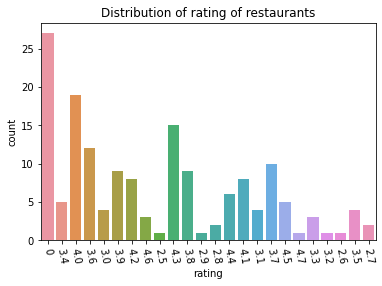

In [73]:
ax=sns.countplot(zomato_venues['rating'])
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=-80)
ax.set_title("Distribution of rating of restaurants")

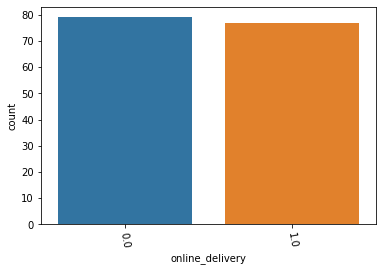

In [74]:
ax=sns.countplot(zomato_venues['online_delivery'])
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=-80)

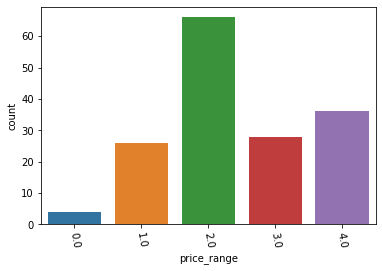

In [75]:
ax=sns.countplot(zomato_venues['price_range'])
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=-80)

# Clustering

Let cluster our historic sites and resturants 


In [84]:
foursquare_venues.head()
#df_clustering=foursquare_venues[["confirmed","active","venue.location.lat","venue.location.lng", "venue.categories", "district"]]
df_clustering=foursquare_venues[["confirmed","active","venue.location.lat","venue.location.lng"]]

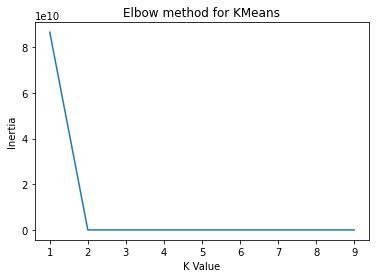

In [85]:
sum_squared_distance=[]

for k in range(1,10):
    kmeans=KMeans(n_clusters=k).fit(df_clustering)
    kmeans.predict(df_clustering)
    sum_squared_distance.append(kmeans.inertia_)

#Let's plot the graph now to find the optimal 'k'

plt.plot(range(1,10),sum_squared_distance)
plt.title("Elbow method for KMeans")
plt.xlabel("K Value")
plt.ylabel("Inertia")
plt.show()

In [100]:
#del foursquare_venues['cluster_label']

In [101]:
kmeans=KMeans(n_clusters=2).fit(df_clustering)
kmeans.predict(df_clustering)
foursquare_venues.insert(0,'cluster_label',kmeans.labels_)
#foursquare_venues.del('cluster_label')
foursquare_venues.head()

foursquare_venues["cluster_label"].value_counts()

1    100
0     60
Name: cluster_label, dtype: int64

In [104]:
cluster_map = folium.Map(location=[agra_lat,agra_long],zoom_start=8)
#color_map = { 0: 'green', 1: 'red', 2: 'blue'}
color_map = {  0: 'red', 1: 'blue'}

for venue, cluster, latitude, longitude in zip(foursquare_venues['venue.name'], foursquare_venues['cluster_label'], 
                                               foursquare_venues['venue.location.lat'], 
                                                foursquare_venues['venue.location.lng']):
    label = folium.Popup(str(venue) + ', Cluster:' + str(cluster), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = color_map[cluster],
        fill = True,
        fill_color = color_map[cluster],
        fill_opacity = 0.7).add_to(cluster_map)
cluster_map